<a href="https://colab.research.google.com/github/umarmohammed/measuring-bias-in-a-dataset/blob/project-3/4.%20Recompute%20bias%20metrics%20on%20the%20transformed%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load the dataset

In [2]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the datset into a pandas dataframe
from joblib import load

data = load("/content/drive/MyDrive/liveProject/mortgage_data_preprocess.pkl.gz")

X = data[0]
y = data[1]

# Concatonate the data into a dataframe
import pandas as pd

df = pd.concat([X, y], axis=1)

## 2. Compute and chart bias metrics on the dataset

In [4]:
# install AIF360
!pip install aif360

     |████████████████████████████████| 174kB 3.6MB/s 


In [5]:
# Create a BinaryLabelDataset
from aif360.datasets import BinaryLabelDataset
dataset = BinaryLabelDataset(df=df, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

In [6]:
# Create a BinaryLabelDatasetMetric
from aif360.metrics import BinaryLabelDatasetMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]

metric = BinaryLabelDatasetMetric(dataset, unprivileged_group, privileged_group)

In [7]:
# Compute equal opportunity metrics
import pandas as pd 

def compute_fair_metrics(metric):
  fair_metrics = {
    "DispImpact": [metric.disparate_impact, 0.8, 1.2], 
    "StatParity": [metric.statistical_parity_difference, -0.1, 0.1] 
    }

  metrics = [[ff, fair_metrics[ff][0](), fair_metrics[ff][1], fair_metrics[ff][2]] for ff in fair_metrics]

  return pd.DataFrame(metrics, columns=["Metric", "Value", "Min", "Max"])

df_fair = compute_fair_metrics(metric)

df_fair

,Metric,Value,Min,Max
0,DispImpact,1.137718,0.8,1.2
1,StatParity,0.066178,-0.1,0.1


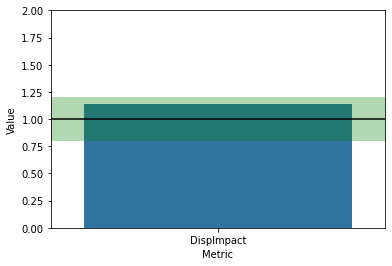

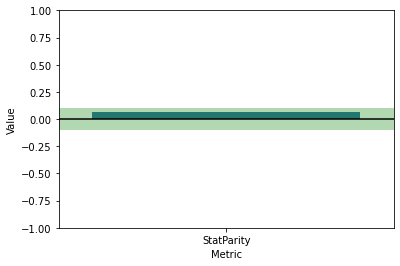

In [8]:
# Chart the metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

def plot_metrics(df_fair): 
  def plot_metric(metric, ylim):
    fig, ax = plt.subplots()
    ax = sns.barplot(data=metric, x="Metric", y="Value")
    plt.axhline(np.mean(metric[["Min", "Max"]].values), color='black')
    plt.ylim(*ylim)
    range_height = metric[["Max"]].values[0][0] - metric[["Min"]].values[0][0]
    ax.add_patch(patches.Rectangle((-1, metric[["Min"]].values[0][0]), 2 , range_height, facecolor="green", alpha=0.3))

  plot_metric(df_fair.iloc[[0]], (0, 2))
  plot_metric(df_fair.iloc[[1]], (-1, 1))

plot_metrics(df_fair)

## 3. Pre-process the model using Reweighing Subjects

In [9]:
# Use the reweighing subjects technique

from aif360.algorithms.preprocessing import Reweighing

rw = Reweighing(unprivileged_group, privileged_group)

dataset_transformed = rw.fit_transform(dataset)

## 4. Recompute bias metrics on the transformed data

In [12]:
# Create a BinaryLabelDatasetMetric

metric_transformed = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_group, privileged_group)

In [13]:
# Compute equal opportunity metrics

df_fair = compute_fair_metrics(metric_transformed)
df_fair

,Metric,Value,Min,Max
0,DispImpact,1.000000e+00,0.8,1.2
1,StatParity,2.220446e-16,-0.1,0.1


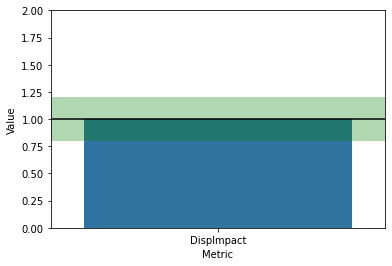

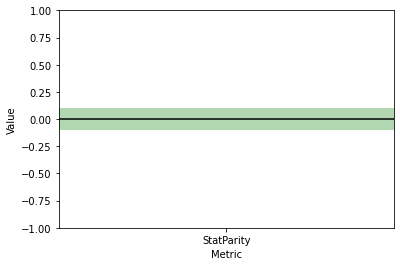

In [14]:
# Chart the metrics

plot_metrics(df_fair)

In [17]:
# Convert the result to a more general format

df = dataset_transformed.convert_to_dataframe()[0]
instance_weights = dataset_transformed.instance_weights


In [31]:
# Train a logistic regression classifier on the result

from sklearn.linear_model import LogisticRegression

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

lr = LogisticRegression()
lr.fit(X, y, sample_weight=instance_weights)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)